## 1. Data Loading

In [1]:
import pandas as pd
from matplotlib import pylab as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [2]:
location = r'C:\Users\86138\Desktop\Techlent\week15\sentiment.csv'
df = pd.read_csv(location)

In [3]:
df

,sentiment,review
0,1,With all this stuff going down at the moment w...
1,1,"\The Classic War of the Worlds\"" by Timothy Hi..."
2,0,The film starts with a manager (Nicholas Bell)...
3,0,It must be assumed that those who praised this...
4,1,Superbly trashy and wondrously unpretentious 8...
...,...,...
4995,0,Is this film a joke? Is it a comedy? Surely it...
4996,1,Don't waste time reading my review. Go out and...
4997,0,"The secret is...this movie blows. Sorry, but i..."
4998,1,After reading the original play I thought it w...


In [4]:
texts = df["review"]

## 2. Topic Modeling

In [5]:
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
from nltk.stem.snowball import EnglishStemmer
import re

In [6]:
def stem_tokenizer(text):
    stemmer = EnglishStemmer(ignore_stopwords=True)
    words = re.sub(r"[^A-Za-z0-9\-]", " ", text).lower().split()
    words = [stemmer.stem(word) for word in words]
    return words 

In [7]:
tfidf = TfidfVectorizer(stop_words=stopwords.words('english'),
                        tokenizer=stem_tokenizer,
                        lowercase=True,
                        max_df=0.5,
                        min_df=5
                       )

In [8]:
X = tfidf.fit_transform(texts).todense()

In [9]:
len(tfidf.vocabulary_)

8417

### 2.2.1 LSA/LSI

<font color='red'>Question:</font> What are Latent Semantic Analysis (LSA) and Latent Semantic Indexing (LSI)? What is the relationship between LSA/LSI and PCA/SVD?

**Example**: Determine number of topics

In [10]:
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler


In [11]:
lsa = TruncatedSVD(n_components=20)
lsa_pipe = Pipeline([('scaler', StandardScaler()), ('lsa', lsa)])
transformed_X = lsa_pipe.fit_transform(X)

<BarContainer object of 20 artists>

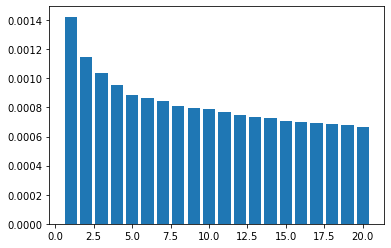

In [12]:
var_ratio = lsa_pipe['lsa'].explained_variance_ratio_
plt.bar(range(1, len(var_ratio) + 1), var_ratio)

**Example**: Group the texts into four topics

In [13]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import Pipeline

In [14]:
lsa = TruncatedSVD(n_components=4)
lsa_pipe = Pipeline([('scaler', StandardScaler()), ('lsa', lsa)])
transformed_X = lsa_pipe.fit_transform(X)

In [15]:
lsa_topics = pd.DataFrame(transformed_X)
lsa_topics.head()

,0,1,2,3
0,-0.700259,3.729314,-0.500380,-0.132393
1,-0.869249,-3.290778,-1.093728,2.008010
2,6.483649,10.035375,6.202583,-5.158502
3,5.179040,-1.487852,-2.741036,3.913172
4,3.930392,5.920150,3.440411,4.018833


**Example**: Decide which topic a text belongs to

In [16]:
import numpy as np

In [17]:
lsa_topics['which_topic'] = lsa_topics.apply(lambda x: x.idxmax(), axis=1)

In [18]:
lsa_topics.head()

,0,1,2,3,which_topic
0,-0.700259,3.729314,-0.500380,-0.132393,1
1,-0.869249,-3.290778,-1.093728,2.008010,3
2,6.483649,10.035375,6.202583,-5.158502,1
3,5.179040,-1.487852,-2.741036,3.913172,0
4,3.930392,5.920150,3.440411,4.018833,1


Text(0, 0.5, 'topic 1')

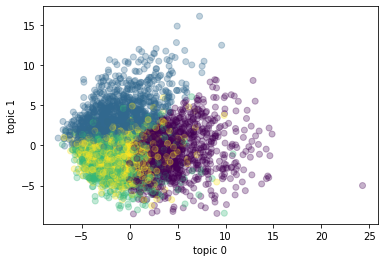

In [19]:
plt.scatter(lsa_topics[0], lsa_topics[1], alpha=0.3, c=lsa_topics['which_topic'])
plt.xlabel('topic 0')
plt.ylabel('topic 1')

**Example**: Find important words for each topic

In [20]:
words = [''] * len(tfidf.vocabulary_)
for k, v in tfidf.vocabulary_.items():
    words[v] = k

In [21]:
for i in range(4):
    topic_words = list(zip(words, lsa_pipe['lsa'].components_[i]))
    topic_words.sort(key=lambda x: x[1], reverse=True)
    print('--- topic {} ---'.format(i))
    for j in range(5):
        print(topic_words[j])
    print('...')
    for j in range(5):
        print(topic_words[- j - 1])
    print('')

--- topic 0 ---
('whose', 0.05080490937953356)
('young', 0.04873733589970567)
('man', 0.04776511966087771)
('becom', 0.04435235649726666)
('preming', 0.0431713568692904)
...
('watch', -0.0665977627941154)
('bad', -0.06091065168960599)
('worst', -0.05656099034302234)
('wast', -0.052143053323681514)
('funni', -0.051380492788968515)

--- topic 1 ---
('kill', 0.08227006827638499)
('horror', 0.07242823692853434)
('get', 0.07094086653567375)
('bad', 0.07056514376803046)
('even', 0.06339572718695954)
...
('perform', -0.05705839790211837)
('love', -0.05468077380820081)
('great', -0.05136477308170515)
('role', -0.046960770353142584)
('excel', -0.045528081860202546)

--- topic 2 ---
('wwe', 0.19519672615021244)
('match', 0.1720931635669699)
('ppv', 0.17077403131778857)
('intercontinent', 0.16707827331331723)
('tripl', 0.14996282596902147)
...
('feel', -0.04566537394149784)
('charact', -0.044915541911573785)
('emot', -0.04318239078626121)
('stori', -0.03890000757196606)
('director', -0.0344805769

### 2.2.2 NMF

In [22]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import NMF

In [23]:
nmf = NMF(n_components=4)
nmf_pipe = Pipeline([('scaler', MinMaxScaler()), ('nmf', nmf)])
transformed_X = nmf_pipe.fit_transform(X)

In [24]:
nmf_topics = pd.DataFrame(transformed_X)
nmf_topics.head()

,0,1,2,3
0,0.049137,0.182914,0.042252,0.016874
1,0.020053,0.027161,0.047662,0.053892
2,0.086091,0.000000,0.104954,0.000000
3,0.047849,0.014802,0.107409,0.014784
4,0.063856,0.075550,0.033944,0.018446


In [25]:
nmf_topics['which_topic'] = nmf_topics.apply(lambda x: x.idxmax(), axis=1)

In [26]:
nmf_topics

,0,1,2,3,which_topic
0,0.049137,0.182914,0.042252,0.016874,1
1,0.020053,0.027161,0.047662,0.053892,3
2,0.086091,0.000000,0.104954,0.000000,2
3,0.047849,0.014802,0.107409,0.014784,2
4,0.063856,0.075550,0.033944,0.018446,1
...,...,...,...,...,...
4995,0.061330,0.048837,0.079128,0.000000,2
4996,0.000000,0.024717,0.062386,0.061237,2
4997,0.038448,0.067379,0.026923,0.000000,1
4998,0.026614,0.000000,0.055488,0.079884,3


Text(0, 0.5, 'topic 1')

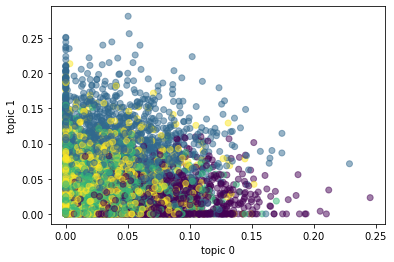

In [27]:
plt.scatter(nmf_topics[0], nmf_topics[1], alpha=0.5, c=lsa_topics['which_topic'])
plt.xlabel('topic 0')
plt.ylabel('topic 1')

In [28]:
for i in range(4):
    topic_words = list(zip(words, nmf_pipe['nmf'].components_[i]))
    topic_words.sort(key=lambda x: x[1], reverse=True)
    print('--- topic {} ---'.format(i))
    for j in range(5):
        print(topic_words[j])
    print('...')
    for j in range(5):
        print(topic_words[- j - 1])
    print('')

--- topic 0 ---
('take', 1.0662847631210697)
('way', 1.0170270170736437)
('two', 0.7658651187360899)
('live', 0.6503656696900832)
('man', 0.6407195615957958)
...
('zoom', 0.0)
('zeta-jon', 0.0)
('zelah', 0.0)
('youtub', 0.0)
('yike', 0.0)

--- topic 1 ---
('even', 0.9494250693817382)
('bad', 0.6928941787143712)
('make', 0.6924868901992912)
('go', 0.6873412119831185)
('say', 0.6511156311822628)
...
('zoe', 0.0)
('zelah', 0.0)
('zealand', 0.0)
('yuppi', 0.0)
('yummi', 0.0)

--- topic 2 ---
('charact', 1.5658188354850597)
('much', 0.7761396548217074)
('scene', 0.6663581152671634)
('though', 0.6591436342499648)
('set', 0.5965825931451544)
...
('zoo', 0.0)
('zoe', 0.0)
('zero', 0.0)
('zani', 0.0)
('yuck', 0.0)

--- topic 3 ---
('time', 1.2988227563226848)
('great', 1.0976107985156205)
('love', 1.0529504084784393)
('year', 0.628844289031823)
('watch', 0.6155238145768122)
...
('zoom', 0.0)
('zombi', 0.0)
('zeta-jon', 0.0)
('zero', 0.0)
('zani', 0.0)



### 2.2.3 K-Means

We can use the clustering algorithms introduced in Basic ML couses. We use k-Means in this case.

**Example**: Reduce the dimension of document vectors.

In [29]:
lsa = TruncatedSVD(n_components=30)
lsa_pipe = Pipeline([('scaler', StandardScaler()), ('lsa', lsa)])
transformed_X = lsa_pipe.fit_transform(X)

In [30]:
km_data = pd.DataFrame(transformed_X)
km_data.head()  

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
0,-0.849957,3.901194,-0.342413,-0.122976,-0.013758,1.314720,1.515333,1.087694,-1.427569,2.507803,...,2.520404,-0.037765,1.037128,0.270641,-1.169294,1.134318,-1.799205,1.368650,0.308205,0.777117
1,-1.016465,-3.185966,-1.689430,2.333120,-1.298291,-1.821194,-3.156325,0.903967,1.776701,-0.243247,...,-0.624250,-1.559977,1.808070,-1.422169,-0.792769,-1.174957,1.567154,-0.314053,-0.214353,-1.789649
2,7.507637,8.747086,8.960769,-5.414004,-5.886954,-0.084682,-5.609564,5.394846,-1.784716,-5.690986,...,4.604201,1.803562,-0.855271,4.846651,1.129725,2.730327,-5.198149,0.708852,3.208787,2.007450
3,5.099501,-1.446889,-3.030346,2.984801,-2.107116,-4.611401,1.904973,4.025863,2.162752,1.134415,...,-3.233324,2.628370,-1.059528,7.452851,-2.711419,0.263533,0.558189,-6.267774,1.267828,4.652595
4,4.152601,5.588414,2.844547,-1.372282,-1.964235,3.270304,-0.661211,1.186713,-0.642106,-2.830952,...,-0.606995,4.623270,-1.199163,-0.326753,-3.134015,2.069806,0.077472,-3.707663,-0.431517,-4.596119


<font color='red'>Question:</font> What is curse of dimensionality?

**Example**: Determine k.

In [31]:
from sklearn.cluster import KMeans

In [32]:
inertia = []
for i in range(1, 10):
    km = KMeans(n_clusters=i)
    km.fit(transformed_X)
    inertia.append(km.inertia_)

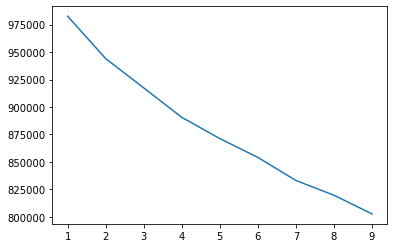

In [33]:
plt.plot(range(1,10), inertia)

Usually, we don't see any elbow in the curve, but we still need to choose a k. We choose 3 here.

In [34]:
km = KMeans(n_clusters=3)
km.fit(transformed_X)

KMeans(n_clusters=3)

In [35]:
km_data['label'] = km.labels_

In [36]:
km_data.head()

,0,1,2,3,4,5,6,7,8,9,...,21,22,23,24,25,26,27,28,29,label
0,-0.849957,3.901194,-0.342413,-0.122976,-0.013758,1.314720,1.515333,1.087694,-1.427569,2.507803,...,-0.037765,1.037128,0.270641,-1.169294,1.134318,-1.799205,1.368650,0.308205,0.777117,2
1,-1.016465,-3.185966,-1.689430,2.333120,-1.298291,-1.821194,-3.156325,0.903967,1.776701,-0.243247,...,-1.559977,1.808070,-1.422169,-0.792769,-1.174957,1.567154,-0.314053,-0.214353,-1.789649,2
2,7.507637,8.747086,8.960769,-5.414004,-5.886954,-0.084682,-5.609564,5.394846,-1.784716,-5.690986,...,1.803562,-0.855271,4.846651,1.129725,2.730327,-5.198149,0.708852,3.208787,2.007450,0
3,5.099501,-1.446889,-3.030346,2.984801,-2.107116,-4.611401,1.904973,4.025863,2.162752,1.134415,...,2.628370,-1.059528,7.452851,-2.711419,0.263533,0.558189,-6.267774,1.267828,4.652595,0
4,4.152601,5.588414,2.844547,-1.372282,-1.964235,3.270304,-0.661211,1.186713,-0.642106,-2.830952,...,4.623270,-1.199163,-0.326753,-3.134015,2.069806,0.077472,-3.707663,-0.431517,-4.596119,0


**Example**: Plot the k means results projected on the first two components.

Text(0, 0.5, 'LSA Component 1')

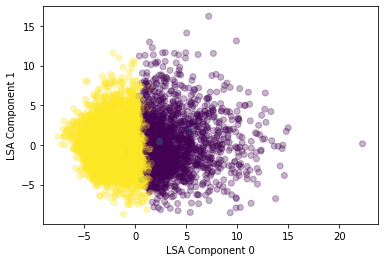

In [37]:
plt.scatter(km_data[0], km_data[1], c=km_data['label'], alpha=0.3)
plt.xlabel('LSA Component 0')
plt.ylabel('LSA Component 1')

### 2.2.4 LDA

In [38]:
from sklearn.decomposition import LatentDirichletAllocation

In [39]:
LDA = LatentDirichletAllocation(n_components=4)

In [40]:
lda_pipe = Pipeline([('scaler', MinMaxScaler()), ('lda', LDA)])

In [41]:
transformed_X = lda_pipe.fit_transform(X)

In [42]:
lda_topics = pd.DataFrame(transformed_X)
lda_topics.head()

,0,1,2,3
0,0.977861,0.007359,0.007385,0.007395
1,0.012138,0.012122,0.012024,0.963717
2,0.653914,0.005855,0.164377,0.175854
3,0.659234,0.006954,0.326747,0.007065
4,0.664230,0.323438,0.006265,0.006068


In [43]:
lda_topics['which_topic'] = lda_topics.apply(lambda x: x.idxmax(), axis=1)

In [44]:
lda_topics.head()

,0,1,2,3,which_topic
0,0.977861,0.007359,0.007385,0.007395,0
1,0.012138,0.012122,0.012024,0.963717,3
2,0.653914,0.005855,0.164377,0.175854,0
3,0.659234,0.006954,0.326747,0.007065,0
4,0.664230,0.323438,0.006265,0.006068,0


Text(0, 0.5, 'topic 1')

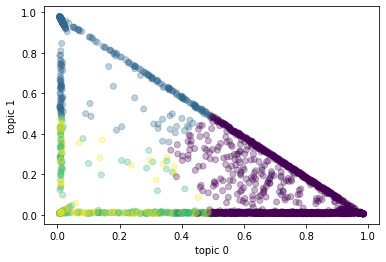

In [45]:
plt.scatter(lda_topics[0], lda_topics[1], alpha=0.3, c=lda_topics['which_topic'])
plt.xlabel('topic 0')
plt.ylabel('topic 1')

<font color='red'>Question:</font> What is LDA?